# Extended LSTM Model Implementation and Performance Evaluation 

## Import Libraries

In [1]:
import math
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import pandas as pd
import random as rd
from random import choices
import numpy as np
import sys

import scipy as sp
from scipy.ndimage.interpolation import shift

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras import optimizers
from keras.utils import multi_gpu_model
from keras.callbacks import CSVLogger

Using TensorFlow backend.


## Python Progress Bar

In [2]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

## Load dataset from csv files

In [3]:
train = pd.read_csv('training.csv')
validation  = pd.read_csv('validation.csv')
test  = pd.read_csv('test.csv')

## Training Data Pre-processing 

In [4]:
X_TRAIN = [[[]*1]*10]*19990
X_TRAIN = np.array(X_TRAIN)
Y_TRAIN = [[]*1]*19990
Y_TRAIN = np.array(Y_TRAIN)
for j in progressbar(range(0,100)):
    X_train = []
    Y_train = []
    t = np.array(train.iloc[j, :]).reshape(-1,1)
    for i in range(10, 20000):
        X_train.append(t[i-10:i, 0])
        Y_train.append(t[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    Y_train = np.reshape(Y_train, (Y_train.shape[0],1))
    X_TRAIN = np.concatenate((X_TRAIN, X_train),axis=2)
    Y_TRAIN = np.concatenate((Y_TRAIN, Y_train),axis=1)

[############################################################] 100/100


In [5]:
X_TRAIN.shape

(19990, 10, 100)

In [6]:
Y_TRAIN.shape

(19990, 100)

## Validation Data Pre-processing 

In [7]:
X_VAL = [[[]*1]*10]*19990
X_VAL = np.array(X_VAL)
Y_VAL = [[]*1]*19990
Y_VAL = np.array(Y_VAL)
for j in progressbar(range(0,100)):
    X_validation = []
    Y_validation = []
    t = np.array(train.iloc[j, :]).reshape(-1,1)
    for i in range(10, 20000):
        X_validation.append(t[i-10:i, 0])
        Y_validation.append(t[i, 0])
    X_validation, Y_validation = np.array(X_validation), np.array(Y_validation)
    X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
    Y_validation = np.reshape(Y_validation, (Y_validation.shape[0],1))
    X_VAL = np.concatenate((X_VAL, X_validation),axis=2)
    Y_VAL = np.concatenate((Y_VAL, Y_validation),axis=1)

[############################################################] 100/100


## Test Data Pre-processing 

In [8]:
X_TEST = [[[]*1]*10]*19990
X_TEST = np.array(X_TEST)
Y_TEST = [[]*1]*19990
Y_TEST = np.array(Y_TEST)
for j in progressbar(range(0,100)):
    X_test = []
    Y_test = []
    t = np.array(test.iloc[j, :]).reshape(-1,1)
    for i in range(10, 20000):
        X_test.append(t[i-10:i, 0])
        Y_test.append(t[i, 0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0],1))
    X_TEST = np.concatenate((X_TEST, X_test),axis=2)
    Y_TEST = np.concatenate((Y_TEST, Y_test),axis=1)

[############################################################] 100/100


## Initial LSTM Model

In [9]:
regressor = Sequential()

# Adding a input LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_TRAIN.shape[1], 100)))

# Adding the output layer
regressor.add(Dense(units = 100))

csv_logger1 = CSVLogger('100MTDlog.csv', append=True, separator=',')

# Compiling the RNN
history1 = regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['binary_accuracy'])

# Fitting the RNN to the Training set
regressor.summary();
history1 = regressor.fit(X_TRAIN, Y_TRAIN, batch_size = 200, validation_data=(X_VAL, Y_VAL), epochs = 100, callbacks=[csv_logger1])
score = regressor.evaluate(X_VAL, Y_VAL)
print('Validation loss    :', score[0])
print('Validation accuracy:', score[1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
Total params: 90,500
Trainable params: 90,500
Non-trainable params: 0
_________________________________________________________________

Train on 19990 samples, validate on 19990 samples
Epoch 1/100
19990/19990 [==============================] - 4s 207us/step - loss: 0.2408 - binary_accuracy: 0.6121 - val_loss: 0.2036 - val_binary_accuracy: 0.6868
Epoch 2/100
19990/19990 [==============================] - 4s 186us/step - loss: 0.1791 - binary_accuracy: 0.7416 - val_loss: 0.1568 - val_binary_accuracy: 0.7903
Epoch 3/100
19990/19990 [=============================

## Tuned LSTM Model

In [10]:
regressor = Sequential()

# Adding a input LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_TRAIN.shape[1], 100)))
regressor.add(Dropout(0.25))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 300, return_sequences = True))
regressor.add(Dropout(0.25))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 300))
regressor.add(Dropout(0.25))

# Adding the output layer
regressor.add(Dense(units = 100))


# Compiling the RNN
history2 = regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['binary_accuracy'])

# Fitting the RNN to the Training set
regressor.summary();
history1 = regressor.fit(X_TRAIN, Y_TRAIN, batch_size = 200, validation_data=(X_VAL, Y_VAL), epochs = 100, callbacks=[csv_logger1])
score = regressor.evaluate(X_VAL, Y_VAL)
print('Validation loss    :', score[0])
print('Validation accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 150)           150600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

## Mean squared error variation over epochs

In [11]:
history = pd.read_csv('100MTDlog.csv')
history = np.array(history)

In [12]:
history[100:200:1,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

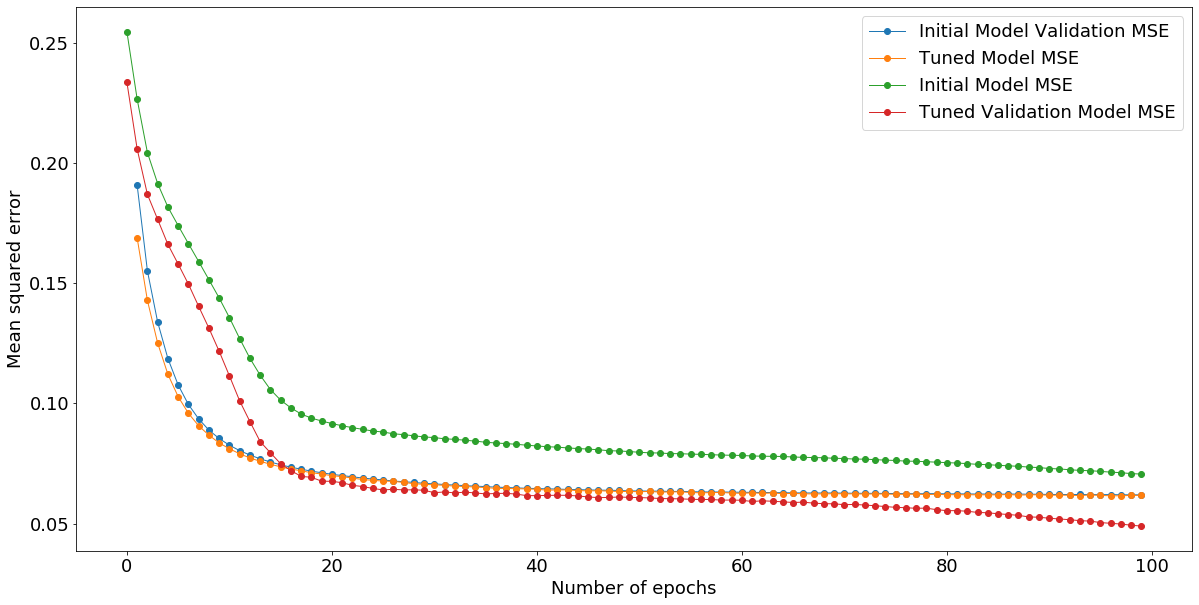

In [13]:
plt.rcParams['figure.figsize']=(20,10)
font ={'size':18}
plt.rc('font',**font)
plt.plot(history[1:100:1,0],history[1:100:1,2],'o-',linewidth=1)
plt.plot(history[1:100:1,0],history[1:100:1,4],'o-',linewidth=1)
plt.plot(history[100:200:1,0],history[100:200:1,2],'o-',linewidth=1)
plt.plot(history[100:200:1,0],history[100:200:1,4],'o-',linewidth=1)
plt.legend(['Initial Model Validation MSE','Tuned Model MSE','Initial Model MSE', 'Tuned Validation Model MSE'])
plt.ylabel('Mean squared error')
plt.xlabel('Number of epochs')
plt.show()

## Model accuracy variation over epochs

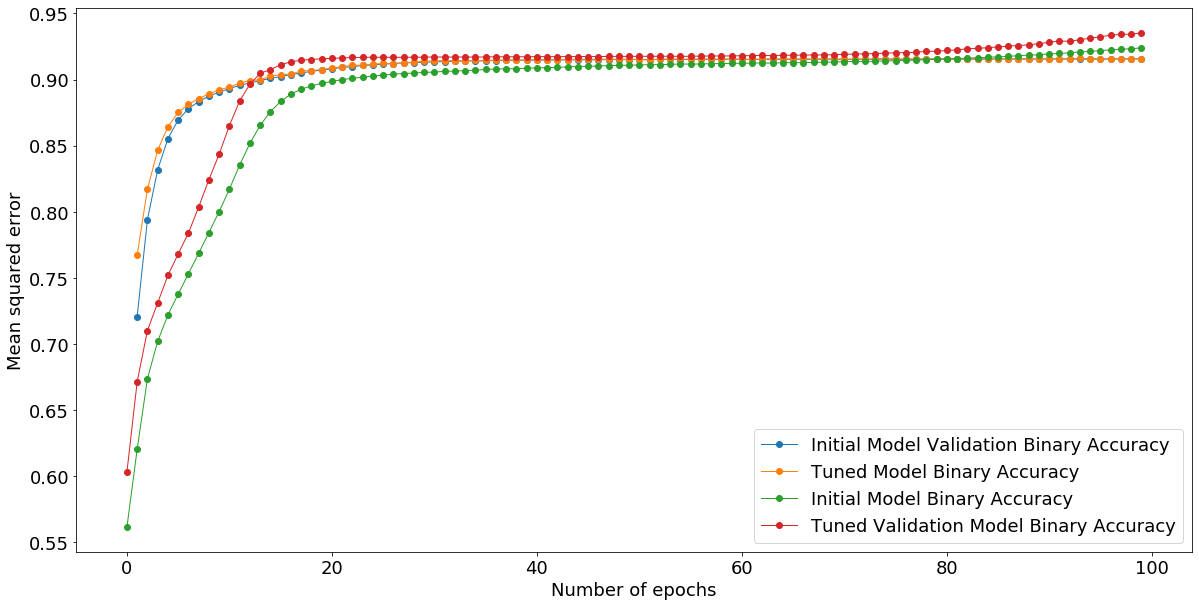

In [14]:
plt.rcParams['figure.figsize']=(20,10)
font ={'size':18}
plt.rc('font',**font)
plt.plot(history[1:100:1,0],history[1:100:1,1],'o-',linewidth=1)
plt.plot(history[1:100:1,0],history[1:100:1,3],'o-',linewidth=1)
plt.plot(history[100:200:1,0],history[100:200:1,1],'o-',linewidth=1)
plt.plot(history[100:200:1,0],history[100:200:1,3],'o-',linewidth=1)
plt.legend(['Initial Model Validation Binary Accuracy','Tuned Model Binary Accuracy',
            'Initial Model Binary Accuracy', 'Tuned Validation Model Binary Accuracy'])
plt.ylabel('Mean squared error')
plt.xlabel('Number of epochs')
plt.show()

## Model Testing

In [15]:
score = regressor.evaluate(X_TEST, Y_TEST)
print('Test Loss    :', score[0])
print('Test Accuracy:', score[1])

19990/19990 [==============================] - 11s 574us/step
Test Loss    : 0.059236963963198504
Test Accuracy: 0.9238961338996887


## Generating predictions

In [16]:
predict = regressor.predict(X_TEST)

## Normalizing prediction outputs

In [17]:
normalized = (predict-np.min(predict))/(np.max(predict)-np.min(predict))

## Mapping normazlied predction outputs to 1 and 0

In [18]:
predicted = np.round(normalized)

## Saving prediction results as csv file for inputing allocations framework

In [19]:
predicted_tx = pd.DataFrame(predicted)
autal_tx = pd.DataFrame(Y_TEST)

predicted_tx.to_csv('autal_tx.csv', index=False)
autal_tx.to_csv('predicted_tx.csv', index=False)

# ##############################################################
## Loading predctions and actual transmission data (Y_TEST)

In [20]:
real_tx = pd.read_csv('autal_tx.csv')
predicted = pd.read_csv('predicted_tx.csv')
actual = np.array(real_tx)
predicted = np.array(predicted)
normalized = (predicted-np.min(predicted))/(np.max(predicted)-np.min(predicted))
predicted = np.round(normalized)

## Define Model Performance Evaluation Function

In [21]:
def accuracy(predicted, actual):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for idx, value in np.ndenumerate(predicted):
        if predicted[idx] == 1 and actual[idx] == 1:
            TP+=1
        elif predicted[idx] == 1 and actual[idx] == 0:
            FP+=1
        elif predicted[idx] == 0 and actual[idx] == 1:
            FN+=1
        elif predicted[idx] == 0 and actual[idx] == 0:
            TN+=1
        
    TP_percentage = (TP / (TP + FP + FN + TN))*100
    FP_percentage = (FP / (TP + FP + FN + TN))*100
    FN_percentage = (FN / (TP + FP + FN + TN))*100
    TN_percentage = (TN / (TP + FP + FN + TN))*100
                
    precision= (TP / (TP + FP))*100 
    sensitivity = (TP / (TP + FN))*100 
    specificity = (TN / (FP + TN) )*100 
    fscore = (2*TP /(2*TP + FP + FN) )*100 
    FDR = (FP / (TP + FP))*100
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    
    return [[TP], [FP], [FN], [TN], 
            [TP_percentage], [FP_percentage], [FN_percentage], [TN_percentage], 
            [precision], [sensitivity], [specificity], [fscore], [FDR] ,[accuracy]]

## Model Performance Evalution

In [22]:
model_evaluation = []
# MTD wise performace evaluation
for i in range(0,100):
    MTDi = accuracy(predicted[:,i],actual[:,i])
    model_evaluation.append(MTDi)
# over all performace evaluation
MTDi = accuracy(predicted,actual)
model_evaluation.append(MTDi)

## Performance Analysis

In [23]:
model_evaluation_array = np.array(model_evaluation)
columns = ["TP", "FP", "FN", "TN", 
           "TP Percentage", "FP Percentage", "FN Percentage", "TN Percentage", 
           "Precision", "RA Redction (Sensitivity)","Specificity", "F-score", "Resource Wastage (False Discovery Rate - FDR)","Accuracy"]
rows= list(range(0,101))
model_evaluation_pd = pd.DataFrame(model_evaluation_array[:,:,0],columns = columns)
model_evaluation_pd = model_evaluation_pd.set_index(pd.Index(rows))
model_evaluation_pd = model_evaluation_pd.round(2)
model_evaluation_pd.to_csv('Model Evaluation.csv', index=False)
model_evaluation_pd

,TP,FP,FN,TN,TP Percentage,FP Percentage,FN Percentage,TN Percentage,Precision,RA Redction (Sensitivity),Specificity,F-score,Resource Wastage (False Discovery Rate - FDR),Accuracy
0,10044.0,0.0,0.0,9946.0,50.25,0.00,0.00,49.75,100.00,100.00,100.00,100.00,0.00,100.00
1,8214.0,3.0,945.0,10828.0,41.09,0.02,4.73,54.17,99.96,89.68,99.97,94.54,0.04,95.26
2,5906.0,34.0,1483.0,12567.0,29.54,0.17,7.42,62.87,99.43,79.93,99.73,88.62,0.57,92.41
3,7952.0,0.0,2011.0,10027.0,39.78,0.00,10.06,50.16,100.00,79.82,100.00,88.77,0.00,89.94
4,6691.0,2.0,742.0,12555.0,33.47,0.01,3.71,62.81,99.97,90.02,99.98,94.73,0.03,96.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,9927.0,0.0,0.0,10063.0,49.66,0.00,0.00,50.34,100.00,100.00,100.00,100.00,0.00,100.00
97,11055.0,0.0,2719.0,6216.0,55.30,0.00,13.60,31.10,100.00,80.26,100.00,89.05,0.00,86.40
98,8934.0,0.0,993.0,10063.0,44.69,0.00,4.97,50.34,100.00,90.00,100.00,94.74,0.00,95.03
99,11827.0,0.0,0.0,8163.0,59.16,0.00,0.00,40.84,100.00,100.00,100.00,100.00,0.00,100.00


In [24]:
MPE = np.array(model_evaluation_pd)

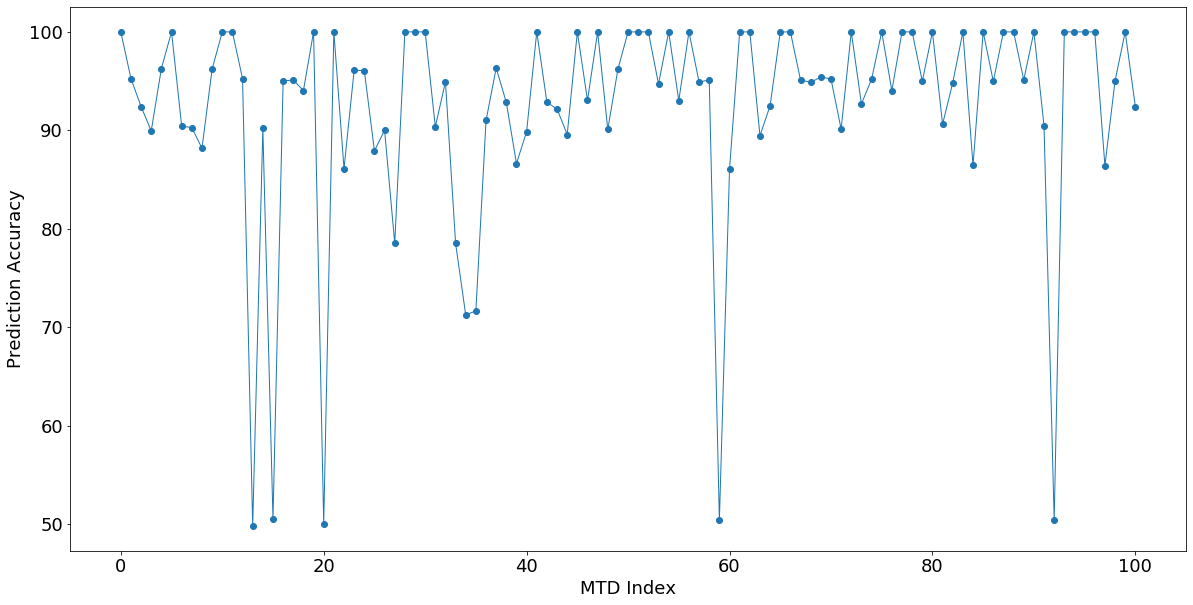

In [25]:
plt.rcParams['figure.figsize']=(20,10)
font ={'size':18}
plt.rc('font',**font)
plt.plot(MPE[:,13],'o-',linewidth=1)
plt.ylabel('Prediction Accuracy')
plt.xlabel('MTD Index')
plt.show()

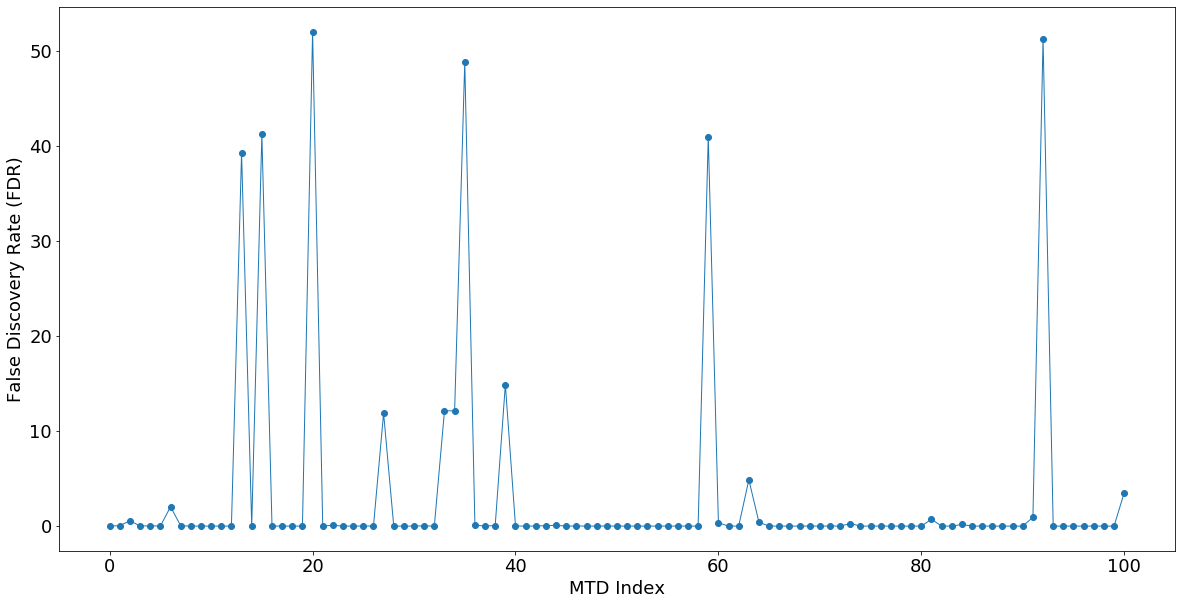

In [26]:
plt.rcParams['figure.figsize']=(20,10)
font ={'size':18}
plt.rc('font',**font)
plt.plot(MPE[:,12],'o-',linewidth=1)
plt.ylabel('False Discovery Rate (FDR)')
plt.xlabel('MTD Index')
plt.show()

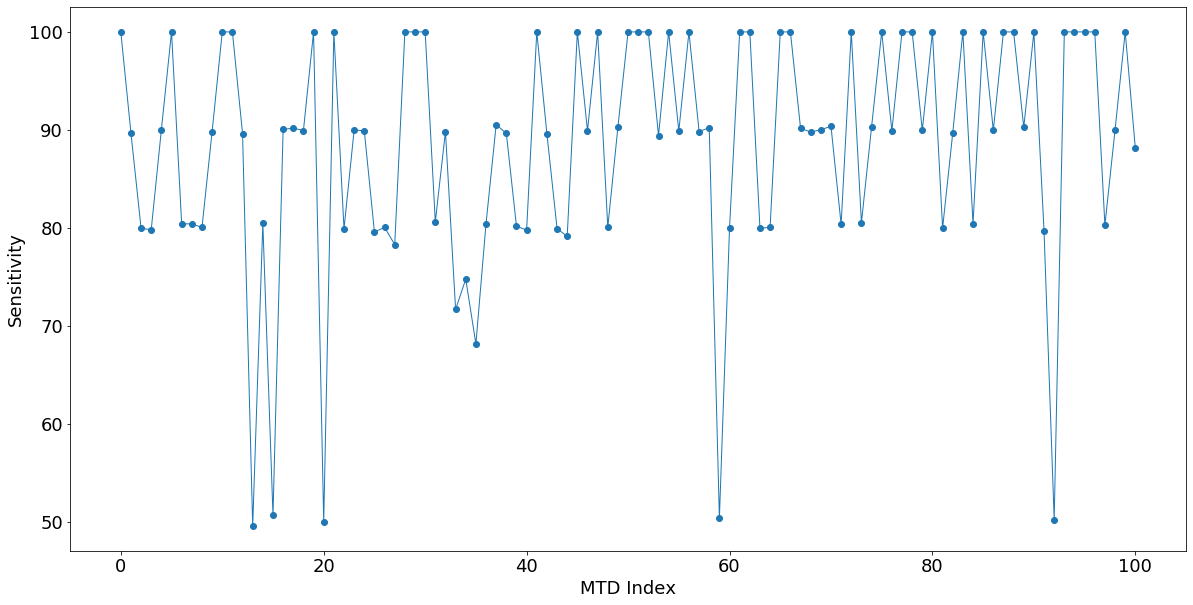

In [27]:
plt.rcParams['figure.figsize']=(20,10)
font ={'size':18}
plt.rc('font',**font)
plt.plot(MPE[:,9],'o-',linewidth=1)
plt.ylabel('Sensitivity')
plt.xlabel('MTD Index')
plt.show()